# Инициализация для BigCLAM

In [1]:
from __future__ import unicode_literals
import numpy as np
import scipy as sp
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import cPickle
from Extends import *
import subprocess
import os
from big_clam import *
from big_clam_gamma import BigClamGamma

# для отрисовки графов
from plotly import tools
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode()

from Experiments import *

%matplotlib inline 

Текущая инициализация выбирается с помощью метода, который называется locally minimal neighborhoods. Выбирается локальный минимум функционала под названием Conductance (проводимость) по всем эгографам. 

Conductance обозначается как $\phi$ и вычисляется для подграфа $S \in G$ как 

$$
\phi(S) = \dfrac{\mathrm{cut}(S)}{\min(\mathrm{vol}(S), \mathrm{vol}( \bar S))}
$$

миниум берется, т.к. Величина рассматривается для "меньшей" выделенной части графа. Здесь

$$\mathrm{cut}(S) = \mathrm{cut}(S, \bar S)=\sum_{\substack{(v,u)\in E\\ v \in S\\ u \in \bar S}} a_{vu},$$

$$\mathrm{vol}(S) =\sum_{(v,u)\in S} a_{vu}.$$

Возьмем стандартный пример для экспериментов и посмотрим, как на нем ведет себя эта величина

In [7]:
def draw_test_sample(F, A, B=None, C=None, x=0):
    Ys = 3
    plt.figure(figsize=(18,6))
    plt.subplot(1, Ys, 1)
    draw_matrix(F, u"Истинное значение F ")
    plt.subplot(1, Ys, 2)
    draw_matrix(A, u"Вероятность появления ребра")
    if C is not None:
        plt.subplot(1, 3, 3)
        draw_matrix(C, "Матрица смежности графа")
matplotlib.rc('font', family='Arial')

(3L, 140L)


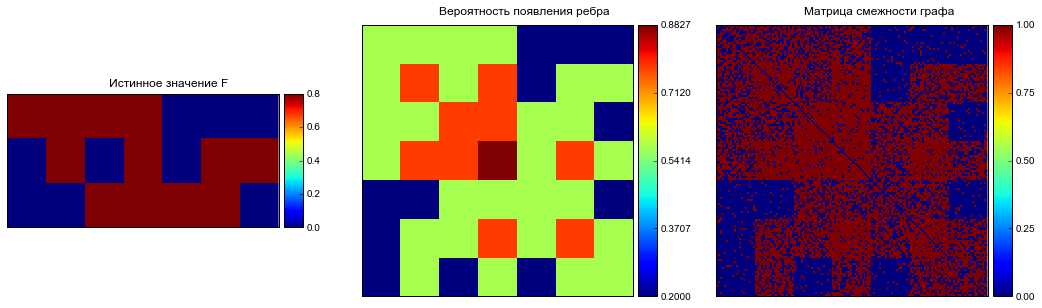

In [8]:
power = 0.17
F_true = 0.4 * Fs3[0]
print F_true.shape
A =  gamma_model_test_data(F_true)

P = 1 - 0.8 * np.exp(- F_true.T.dot(F_true))
np.random.rand(*A.shape)
bord = np.random.rand(*A.shape)

mask = P <= (bord + bord.T) / 2

B = A.copy()
B[mask] = 0
C = B.copy()
C[B != 0] = 1

draw_test_sample(F_true, P, B, C)

In [ ]:
plt.figure(figsize=(12,4))
cond = GetNeighborhoodConductance(nx.from_numpy_matrix(C))
degreeNorm = np.sum(C, axis=0) / np.max(np.sum(C, axis=0))
localmax = conductanceLocalMin(C)
print localmax
plt.plot(cond, 'b')
plt.plot(degreeNorm, 'g--')
plt.plot(localmax, [0]*len(localmax), 'r-o')
plt.xlabel('# node')
plt.ylabel('Neighborhood Conductance')
plt.title('Correlation: {:.3f} '.format(np.corrcoef(cond, degreeNorm)[1][0]))

Видно, что Conductance (синий график) очень хорошо улавливает струкруту матрицы, из которой генерируется граф (зеленый график показывает отнормированную сумму весов каждой из вершин матрицы А).

Посмотрим на эту величину на графе

In [ ]:
def draw_graph(C, pos=None, color=None, highlight=None):

    G = nx.Graph(C)
    if pos is None:
        pos=nx.layout.spectral_layout(G)
        center = sum(pos[key] for key in pos) / len(pos)
        pos = {key:np.sign(pos[key]-center)*(2*(np.abs(pos[key]-center)))**0.6+center for key in pos}

    if color is None:
        color = GetNeighborhoodConductance(C)

    nx.set_node_attributes(G, 'pos', pos)
    nx.set_node_attributes(G, 'cond', color)

    edge_trace = Scatter(
        x=[], y=[],
        line=Line(width=0.15,color='rgba(100, 100, 100, 0.5)'),
        hoverinfo='none', mode='lines')

    for edge in G.edges():
        x0, y0 = G.node[edge[0]]['pos']
        x1, y1 = G.node[edge[1]]['pos']
        edge_trace['x'] += [x0, x1, None]
        edge_trace['y'] += [y0, y1, None]

    node_trace = Scatter(
        x=[], y=[], text=[],
        mode='markers',
        hoverinfo='text',
        marker=Marker(
            showscale=True,
            colorscale='YIGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title=u'Conductance эго-графа вершины',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2, color=[])))

    for node in G.nodes():
        if node in highlight:
            continue
        x, y = G.node[node]['pos']
        node_trace['x'].append(x)
        node_trace['y'].append(y)
        node_trace['marker']['line']['color'].append('#444')
        node_trace['marker']['color'].append(cond[node])
        node_info = '{}: {:.3f}'.format(node, cond[node]) + (' {}'.format(highlight.index(node)) if node in highlight else '' )
        node_trace['text'].append(node_info)
        
    for node in highlight:
        x, y = G.node[node]['pos']
        node_trace['x'].append(x)
        node_trace['y'].append(y)
        node_trace['marker']['line']['color'].append( '#911')
        node_trace['marker']['color'].append(cond[node])
        node_info = '{}: {:.3f}'.format(node, cond[node]) + (' {}'.format(highlight.index(node)) if node in highlight else '' )
        node_trace['text'].append(node_info)

    fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title=u'',
                titlefont=dict(size=16),
                showlegend=False,
                width=800,
                height=650,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))
    
    return fig

In [ ]:
fig = draw_graph(C, highlight=localmax[:3])
py.iplot(fig, filename='networkx', show_link=False)

# Разреженная инициализация

Посмотрим на количество общих вершин в эгографах вершин, где достигается локальный минимум проводимости.

**BTW**: позиции вершин расчитаны с помощью спектрального метода и он очень здорово располагает и отрисовывает такой модельный пример

In [ ]:
Z = C[localmax].dot(C[localmax].T)/np.sum(C[localmax], axis=1)
np.fill_diagonal(Z, 0)
                    
data = [Heatmap(z=Z)]
fig = Figure(data=data, layout=Layout( width=400, height=400,  title=' Nodes interseption fraction'))
py.iplot(fig, filename='Egograph interception', show_link=False)

Видим местами значительные пересечения. Например, берем первый и второй по проводимости эгограф, получаем долю пересеечния в 60%. Это очень много. По первому графику видно, что локальные минимумы есть в каждой из стуктурных частей графа. Попробуем использовать эту матрицу, как матрицу штрафов для выбора сообществ, что и реализованно в функции *getSeedCenters*

In [ ]:
A, B = getSeedCenters(C), conductanceLocalMin(C)
print A, B

In [ ]:
fig = draw_graph(C, highlight=A[:3])
fig['layout'].update(title='')
py.iplot(fig, filename='Network', show_link=True)

Итак, результат достигнут. Начальные точки лежат в разрозненных частях графа. До этого две точки: 12 и 9 лежали в одной части. Такой подход явно поможет избежать подобных ситуаций.

# Новые способы инициализации

В ходе тестовых испытаний, было замечено, что преимущественно нулевые значения матрицы $F$ так и остаются нулями, что может негативно сказываться на качестве полученного решения (привет, bigCLAM!). необходимо заполнять эти нули хотя бы шумом. Тем самым были добавлены новые способы инициализации: *cond_randz* и *cond_new_randz*, где вместо нулевых значений берется равномерный шум от нуля до 0.1(или до параметра *rand_init_coef*, если он установлен)

Возникла идея, что можно вокруг найденного с помощью проводимости начального приближения "распространить" его на соседние вершины. Т.е. дать половину веса (0.5) всем вершинам, соседним к найденному эго-графу. Такие методы имеют приставку *_spr*

**Описание всех методов инициализации:**
* rand — инициализация равномерным шумом от 0.75 до 1.25 
* cond — стандартный метод (берем локальные максимумы)
* cond_new — Новый метод (см выше), штрафуем за пересечение с уже выбранными вершинами
* cond_randz — заменяем нули из метода *cond* на значения от 0 до 0.1(или до параметра *rand_init_coef*, если он установлен)
* cond_new_randz — заменяем нули из метода *cond_new* на значения от 0 до 0.1(или до параметра *rand_init_coef*, если он установлен)
* cond_randz_spr — Применяем метод *cond*. Соседние с найденными сообществами вершины получают половину его веса. Затем заменяем нули матрицы $F$ на значения от 0 до 0.1(или до параметра *rand_init_coef*, если он установлен)
* cond_new_randz_spr — Применяем метод *cond_new*. Соседние с найденными сообществами вершины получают половину его веса. Затем заменяем нули марицы $F$ на значения от 0 до 0.1(или до параметра *rand_init_coef*, если он установлен)


Посмотрим как ведет себя правдоподобие на всех этих инициализациях.

## Модельные данные

In [9]:
K = 3
inits = ['cond', 'cond_new', 'rand', 'cond_randz', 'cond_new_randz', 'cond_randz_spr', "cond_new_randz_spr"]
Fs = []
initFs = []
itersLLH = []
for init in log_progress(inits):
    bigClam = BigClam(C, K, initF=init, debug_output=False, LLH_output=False, eps=1e-4, iter_output=1)
    res = bigClam.fit()
    initFs.append(bigClam.initFmode)
    itersLLH.append(bigClam.LLH_output_vals)
    Fs.append(res[0])

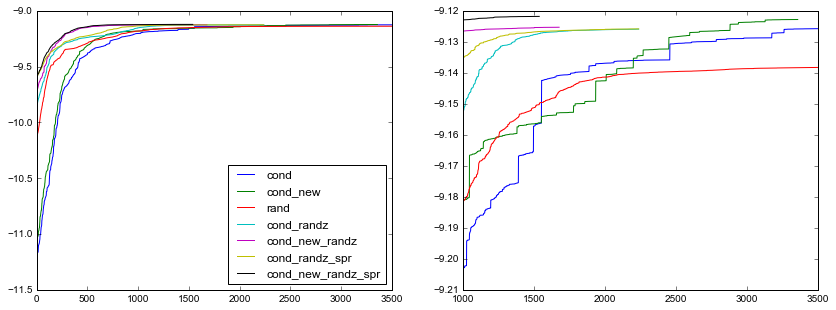

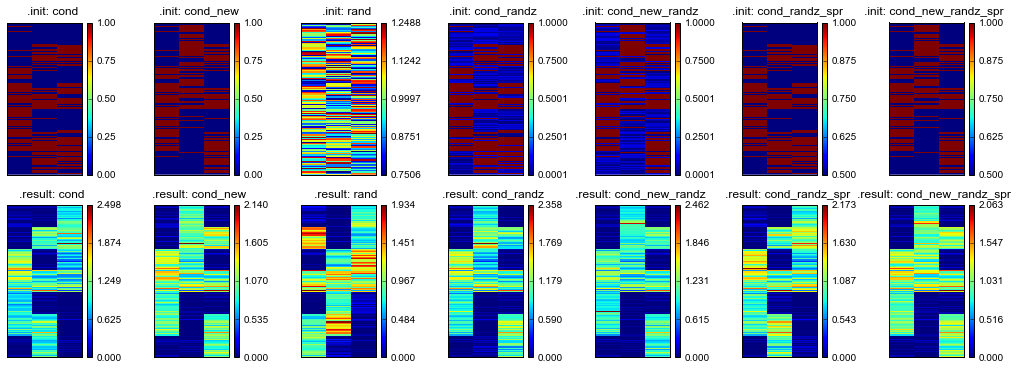

In [10]:
plt.figure(figsize=(14,5))
for llh, init in zip(itersLLH, inits):
    plt.subplot(121)
    plt.plot(-np.log(-np.array(llh)), label=init)
    plt.subplot(122)
    plt.plot(range(1000, len(llh)),-np.log(-np.array(llh[1000:])), label=init)
plt.subplot(121)
plt.legend(loc=4)

plt.figure(figsize=(18,6))
for j, initF in enumerate(initFs):
    plt.subplot(2, len(inits), j+1)
    draw_matrix(initF, '{}.init: {}'.format("", inits[j]))
    plt.subplot(2, len(inits), j+len(Fs)+1)
    draw_matrix(Fs[j], '{}.result: {}'.format("", inits[j]))

## Тест на реальных данных

In [2]:
K = 4
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
#ego_paths = ego_paths[:2]
inits = ['cond', 'cond_new', 'rand', 'cond_randz', 'cond_new_randz', 'cond_randz_spr', "cond_new_randz_spr"]
Fss = []
initFss = []
itersLLHs = []
for indx, ego in enumerate(ego_paths):
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    Fs = []
    initFs = []
    itersLLH = []
    for init in log_progress(inits):
        bigClam = BigClam(A, K, initF=init, debug_output=False, LLH_output=False, eps=1e-4, iter_output=1)
        res = bigClam.fit()
        initFs.append(bigClam.initFmode)
        itersLLH.append(bigClam.LLH_output_vals)
        Fs.append(res[0])
    itersLLHs.append(itersLLH)
    initFss.append(initFs)
    Fss.append(Fs)

C:\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



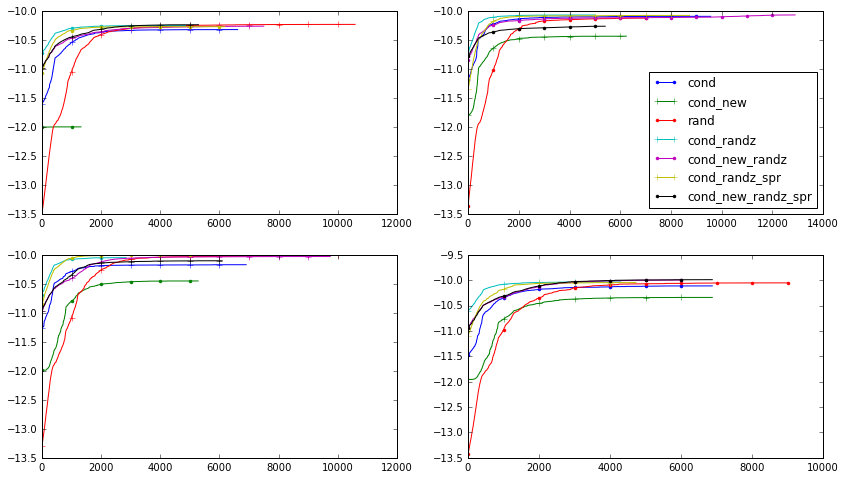

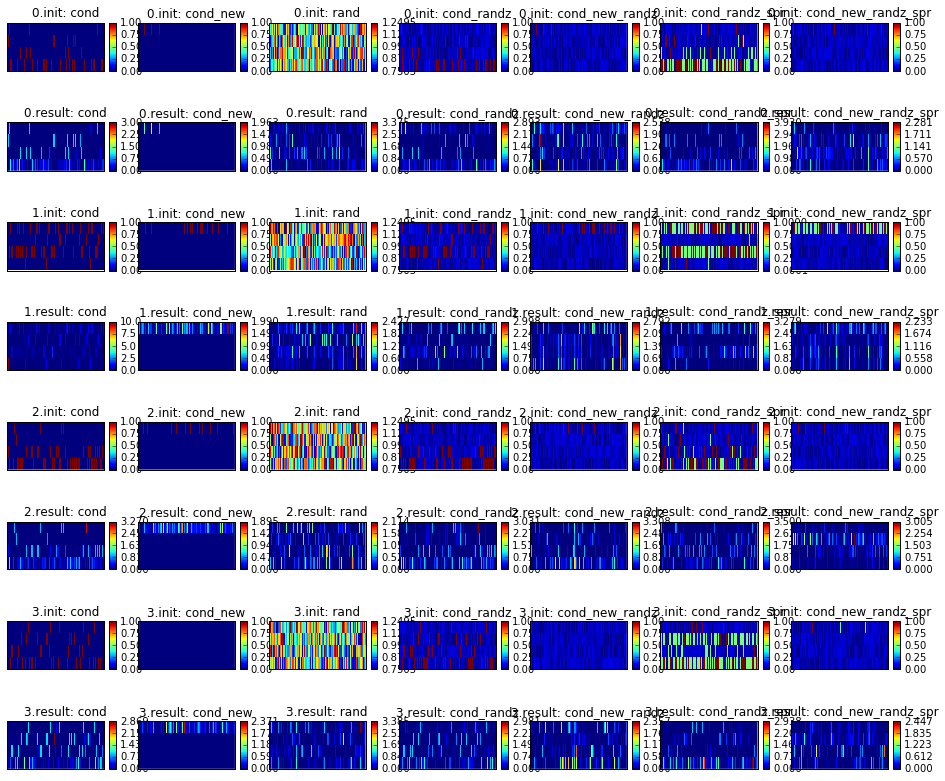

In [3]:
xstart = 0
k=0
plt.figure(figsize=(14,8))
for indx in xrange(len(ego_paths)):
    plt.subplot(2,2,indx+1)
    for llh, init in zip(itersLLHs[indx], inits):
        k+=1
        plt.plot(range(xstart, len(llh)), -np.log(-np.array(llh[xstart:])), label=init if indx == 1 else None, marker='+' if k%2 else '.', markevery=1000)
    plt.legend(loc=4)

plt.figure(figsize=(16,14))
for i, initFs in enumerate(initFss):
    for j, initF in enumerate(initFs):
        plt.subplot(2*len(ego_paths), len(inits), j+2*i*len(Fs)+1)
        draw_matrix(initF.T, '{}.init: {}'.format(i, inits[j]))
        plt.subplot(2*len(ego_paths), len(inits), j+(2*i+1)*len(Fs)+1)
        draw_matrix(Fss[i][j].T, '{}.result: {}'.format(i, inits[j]))

На нижних графиках изображены начальные приближения 5 методами (нечетные строки, init в заголовке) и итоговый результат (четные строки, result в заголовке). Видно, что нулевые значения так и остаются нулями и необходимо хотя бы заполнить шумом, что и сделано в новых методах.

На реальных данных лучше всех работают разные методы. Нужны дополнительные тесты на реальных данных.

Подбираем наилучшее значение параметра *rand_init_coef*, смотрим на поведение процедуры оптимизации:

In [13]:
K = 4
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
rand_init_coefs = [0, 0.01, 0.1, 0.2, 0.3, 0.5, 1]
plt.figure(figsize=(18,12))
Fss = []
initFss = []
itersLLHs = []
for indx, ego in enumerate(ego_paths):
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    Fs = []
    initFs = []
    itersLLH = []
    for ric in log_progress(rand_init_coefs):
        bigClam = BigClam(A, K, initF='cond_randz', debug_output=False, LLH_output=False, eps=1e-2, iter_output=5, rand_init_coef=ric)
        res = bigClam.fit()
        initFs.append(bigClam.initFmode)
        itersLLH.append(bigClam.LLH_output_vals)
        Fs.append(res[0])
    itersLLHs.append(itersLLH)
    initFss.append(initFs)
    Fss.append(Fs)

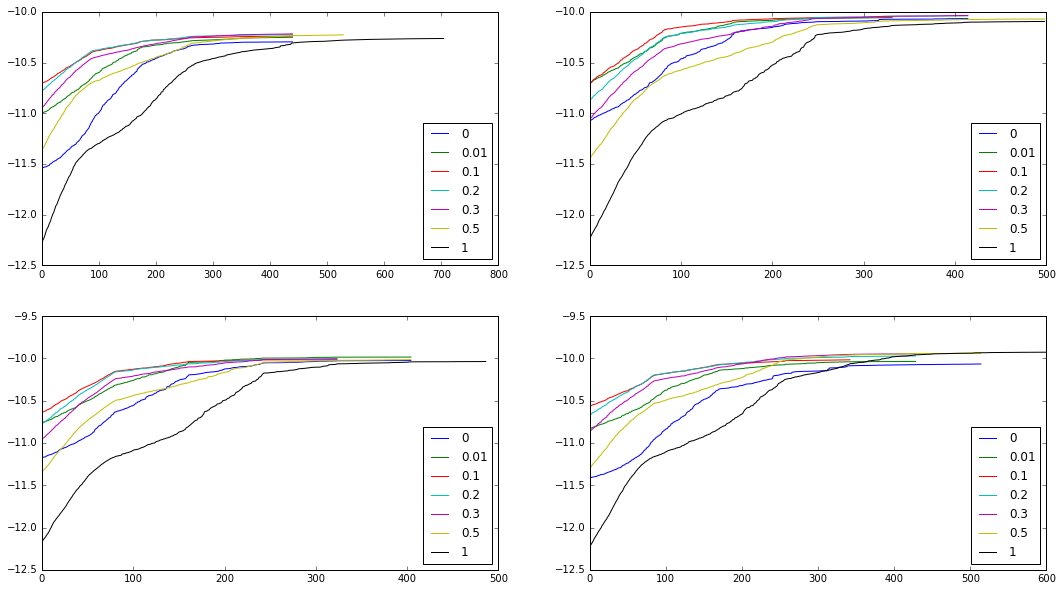

In [14]:
plt.figure(figsize=(18,10))
for indx in xrange(len(ego_paths)):
    plt.subplot(2,2,indx+1)
    for llh, ric in zip(itersLLHs[indx], rand_init_coefs):
        plt.plot(-np.log(-np.array(llh)), label=ric)
    plt.legend(loc=4)
plt.figure(figsize=(6,6))


**Вывод:** Лучше всего себя показывают небольшие значения *rand_init_coef* (на уровне 0.1-0.2). В качестве значения по умолчанию возьмем 0.1 

**Общие выводы:**
* На реальных данных разреженность не дает особого прироста в качестве
* Важно добавить немного шума вместо нулей в матрице F
* "Распространение" сообщества на соседние вершины может еще немного помочь улучшить результат

# Новые тесты на бенчмарке

In [11]:
seed = 213222
data_params = {
    'N': 500,
     'mut': 0.1,
     'maxk': 50,
     'k': 30,
     'om': 2,
     'muw': 0.1,
     'beta': 2,
     't1': 2,
     't2': 2,
     'on': 100,
     }

G, comms = LancichinettiBenchmark(**data_params)
A = np.zeros(shape=(len(G), len(G)))
for u, v, data in G.edges(data=True):
    A[int(u)-1][int(v)-1] = 1 #data['weight']

In [12]:
def mean(lists):
    length = max(len(l) for l in lists)
    N = len(lists)
    res = np.zeros(shape=(length,))
    for i in xrange(length):
        temp = [l[i] for l in lists if len(l) > i]
        res[i] = 1.0 * sum(temp) / len(temp) #if len(temp) > 0 else float('nan')
    return res

In [15]:
N = 5
iter_output=40
inits = ['cond', 'cond_new', 'cond_randz', 'cond_new_randz', 'cond_randz_spr', "cond_new_randz_spr", 'rand']
with file(r'..\external\Lancichinetti benchmark\time_seed.dat', 'w') as f:
    f.write(str(seed))
itersLLHs = []
for n in log_progress(xrange(N)):
    G, comms = LancichinettiBenchmark(**data_params)
    K = len(comms)
    A = np.zeros(shape=(len(G), len(G)))
    for u, v, data in G.edges(data=True):
        A[int(u)-1][int(v)-1] = 1#data['weight']
        
    Fs = []
    initFs = []
    itersLLH = []
    for init in inits:
        print '.',
        bigClam = BigClam(A, K, initF=init, debug_output=False, LLH_output=False, eps=0, iter_output=iter_output, max_iter=3500,)
        res = bigClam.fit()
        initFs.append(bigClam.initFmode)
        itersLLH.append(bigClam.LLH_output_vals)
        Fs.append(res[0])
    itersLLHs.append(itersLLH)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


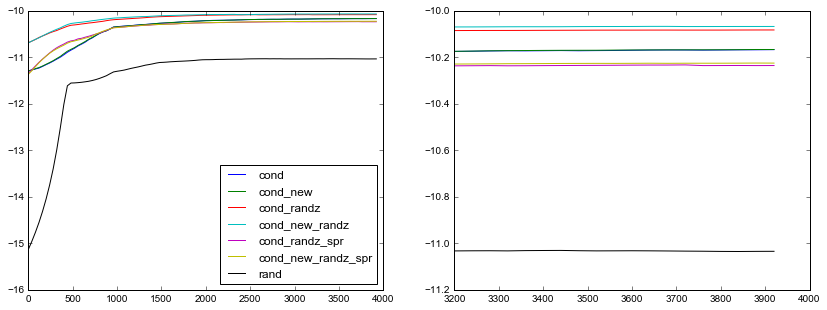

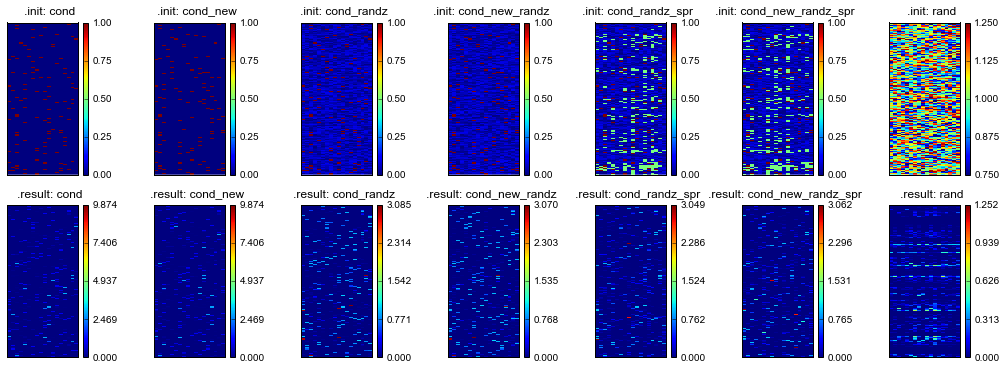

In [16]:
itersLLH = []
for i, init in enumerate(inits):
    itersLLH.append(mean([t[i] for t in itersLLHs]))
#itersLLH = itersLLHs[0]
plt.figure(figsize=(14,5))
for llh, init in zip(itersLLH, inits):
    X = range(0, iter_output*len(llh), iter_output)
    plt.subplot(121)
    plt.plot(X, -np.log(-np.array(llh)), label=init)
    plt.subplot(122)
    plt.plot(X[80:],-np.log(-np.array(llh[80:])), label=init)
plt.subplot(121)
plt.legend(loc=4)

plt.figure(figsize=(18,6))
for j, initF in enumerate(initFs):
    plt.subplot(2, len(inits), j+1)
    draw_matrix(initF, '{}.init: {}'.format("", inits[j]))
    plt.subplot(2, len(inits), j+len(Fs)+1)
    draw_matrix(Fs[j], '{}.result: {}'.format("", inits[j]))

In [29]:
itersLLHs[1][0][0]

-64373.080365727801